In [51]:
# import general libs (probably not required)
#
import matplotlib as mpl
import matplotlib.pyplot as plt 
from numpy import log, log10, log2
import pandas as pd
from os.path import expanduser
from IPython.core.display import display, HTML
from scipy.constants import k, hbar, alpha, pi, speed_of_light, elementary_charge, m_e, physical_constants, N_A
print( " --- constants: \n", k, hbar, alpha, pi, speed_of_light)
# change to source dir to import specific stuff
#
%cd ~/Python/FCCee-Synchrotron-Radiation/source/
import VisualSpecs
from TfsTables import TfsReader, PlotOptics 
from DF_Tools import OutputToDF
from Input import checkRing
from Tools import sbplSetUp


# temporarily disable the SetCopies warning:
# pd.options.mode.chained_assignment = None

# %reload_ext autoreload

# %aimport TfsTables, Input, OpticsSelectTools, Plot, PlotSetup

# %autoreload 1
%matplotlib inline

home = expanduser("~")
plotpath = "/tmp/"

display(HTML("<style>.container { width:100% !important; }</style>"))

# some constants
# beam energy [GeV]
E0 = 45.6
if E0 == 45.6:
    Nbun = 16640
elif E0 == 182.5:
    Nbun = 48
Lrnt = E0/511e-6
brho = 10*E0/2.9979
particle = "positron"
T = 300
P0 = 10e-9 # default pressure, [Pa]
rhoM = P0/(k*T)
r_e = physical_constants['classical electron radius'][0]
print("---- Beam Parameters b1 ---- \n", " Beam energy =", E0, 'with', Nbun, 'bunches/beam'
      "\n Brho =", brho, "\n Lorentz gamma =", Lrnt, 
      "\n def pressure p_0 =", P0, "\n rho_m =", rhoM, "\n ----------------------------- " )

 --- constants: 
 1.38064852e-23 1.0545718001391127e-34 0.0072973525664 3.141592653589793 299792458.0
/home/mlueckhof/Python/FCCee-Synchrotron-Radiation/source


---- Beam Parameters b1 ---- 
  Beam energy = 45.6 with 16640 bunches/beam
 Brho = 152.1064745321725 
 Lorentz gamma = 89236.79060665364 
 def pressure p_0 = 1e-08 
 rho_m = 2414324344716.883 
 ----------------------------- 


In [98]:
MAD_Twiss = TfsReader( home + '/Codes/Projects/FCC-ee-lattice/MadX/output/' + str(E0) + '/fcc_ee_b1_twiss.tfs' ).read_twiss( verbose = 0, relS = 1) 

/usr/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/mlueckhof/Python/FCCee-Synchrotron-Radiation/source/TfsTables.py:34: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df = df.convert_objects(convert_numeric = True)


 Add column 'rel_S' -- S position shifted with IP in the center. Using Lmax =  97756.06428318677


## Elastic Scattering

### Cross-section
The beam-gas elastic scattering can be described according to Rutherford scattering, which is extended to Mott scattering in case of relativistic particles. $$ \begin{equation}
    \frac{d\sigma_{Mott}}{d\Omega} = \left( \frac{Z\alpha\hbar c}{2pv} \right)^2\frac{1 - \beta^2\sin^2\frac{\theta}{2}}{\sin^4\frac{\theta}{2}} \end{equation} $$ 
As this cross estion diverges with $\theta\rightarrow0$, the integration to find the total cross section is only done from a certain $\theta_{min}$, leading to:
$$ \sigma_{Mott}(\theta_{min}) = \pi(\alpha\hbar c)^2\left(\frac{Z}{E_{beam}}\right)^2\left[\frac{1}{1 - \cos\theta_{min}} - \cos\theta_{min} - \ln(1 - \cos\theta_{min}) \right]$$
Considering only very small angles $\theta_{min}$, the first term in the brackets becomes dominating. Further simplifying with $\hbar c = 3.8927\cdot10^{-4} barn GeV^2$

In [99]:
# total CS
#
def RthCS(Z, xmin, xmax):
    return pi*(2*Z*elementary_charge**2/(Lrnt*m_e*speed_of_light**2))**2*(1/xmin**2 - 1/(xmin**2 + xmax**2)**2)

def RthUnscrrened( Z ):
    return 4*pi*alpha**2*3.8927e-4*(Z/E0)**2*1/(45e-6**2)*1e-28

def ThetMin(Z):
    return Z**(1/3)/(192*Lrnt)

# for comparison: Mott CS
#
def MottCS(Z, E0, xmin):
    return 6.5124e-8*(Z/E0)**2*(1/(1 - np.cos(xmin)))

### Angluar Dependence
Look at Rutherford cross sections considering non corrected and corrected case. The uncorrected case scales as $\theta^{-4}$, whereas the corrected description includes a cut off angle $\theta_{min}$:
$$\begin{equation}
    \frac{d\sigma}{d\Omega} \approx \left( \frac{2Ze^2}{\gamma m_0c^2} \right)^2\frac{1}{\left( \theta^2 + \theta_{min}^2 \right)^2}
\end{equation} $$


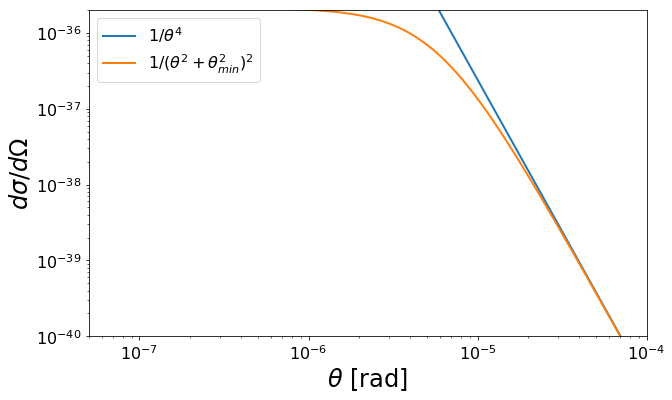

In [100]:
# small angle approximation
#
def RthDef(x, Z):
    return (2*Z*elementary_charge**2/(Lrnt*m_e*speed_of_light**2))**2*1/x**4

# considering also large and very small angles
#
def RthCrr(x, Z, a):
    return (2*Z*elementary_charge**2/(Lrnt*m_e*speed_of_light**2))**2*1/(x**2 + a**2)**2

AngRng = np.arange(5e-8,1e-4,1e-8)
plt.figure( figsize = (10,6) )
plt.plot(AngRng, RthDef(AngRng, 7), label = '$1/\\theta^4$')
plt.plot(AngRng, RthCrr(AngRng, 7, 5.8e-6), label = '$1/(\\theta^2 + \\theta_{min}^2)^2$') ## a: 45e-6
plt.xlim(5e-8,1e-4); plt.xscale('log'); plt.yscale('log')
plt.ylim(1e-40,2e-36); plt.legend();
plt.xlabel('$\\theta$ [rad]'); plt.ylabel('$d\\sigma/d\\Omega$');
# plt.savefig(plotpath + "compareRuthCS.pdf")

### Beam Divergence
Expressed as $\sqrt{\epsilon/\beta}$, this observable can give an impression on the limits on scattering angles that have to be considered. Angles much smaller than the beam divergence don't have to be included in the analysis.

### LEP
Using the parameters from LEP runnings, try to confirm the estimate of $1\mu rad$ beam divergence.

In [101]:
# beta at the IP for the years 94 to 97
#
betxSt = np.array( [2, 2.5, 2.5, 1.5] )
betySt = np.array( [5e-2, 5e-2, 5e-2, 5e-2] )
E = np.array( [45.6, 65, 80.5, 92] )
emtX = np.array( [8.5e-9, 17e-9, 26e-9, 35e-9] )
divgX = np.sqrt(emtX/betxSt)
print(divgX)

[6.51920241e-05 8.24621125e-05 1.01980390e-04 1.52752523e-04]


In [102]:
horDvg = np.array( [4.2e-05, 6.5e-05, 4.6e-05, 3.8e-05] )   
vrtDvg = np.array( [3.2e-05, 4.6e-05, 3.6e-05, 4.3e-05] )



###  Lifetime Estimates
As FCC-ee is a considered to operate at very high energies, the cross section for elastic scattering can be expected to be quite low. 
For an estimate on the lifetime, the worst case is assumed, being a 100% loss on scattered particles.
The lifetime is therefore calculated according to $$ \frac{1}{\tau} = \beta c \rho_m\sigma, $$
where the particle speed is close to c: $\beta = 1$.

In [103]:
# lifetime estimate
#
def tau(sigma):
    return 1/(speed_of_light*sigma*rhoM) 

sigma = RthUnscrrened(7)
print( "cross section at", E0, "=", sigma, "1/m2 <=>", sigma/1e-28 )
print( "lifetime [s] =", tau(sigma), "\n lifetime [h] =", tau(sigma)/3600 ) 

cross section at 45.6 = 3.0313272600562896e-28 1/m2 <=> 3.0313272600562895
lifetime [s] = 4499262.591143652 
 lifetime [h] = 1249.79516420657


## Inelastic Scattering
Interesting for high energy applications: inelastic scattering of electrons off the field of a nucleus. It induces both, change in momentum direction and energy loss by photon radiation. The cross section for high energy eN scattering can be approximated as 
$$ \begin{equation} \sigma_{eN} = 4\alpha r_e^2Z(Z+1)\log\left(\frac{287}{\sqrt{Z}}\right)\left( -\frac{4}{3}\log k_{min} - \frac{5}{6} + \frac{4}{3}k_{min} - \frac{k_{min}^2}{2} \right) \end{equation} $$
In case of N$_2$, the resulting cross section is multiplied by the number of N atoms in the compound. 

In [13]:
# the CS
#
def sigmaBrems(Z, k):
    return 4*alpha*r_e**2*Z*(Z+1)*log(287/np.sqrt(Z))*( -4/3*log(k) - 5/6 + 4/3*k - k**2/2 ) 
def sigmaBrems2(k):
    return A/(N_A*X0)*( -4/3*log(k) - 5/6 + 4/3*k - k**2/2 )

In [25]:
A = 14.0067; X0 = 37.9879
print( sigmaBrems2(0.013) )
print( '2% energy loss, N2: sigma_eN [barn] =', 2*sigmaBrems(7, 0.02)/1e-28)
print( '2% energy loss, N2: sigma_eN [barn] =', sigmaBrems(14, 0.02)/1e-28)

3.0456054995885553e-24
2% energy loss, N2: sigma_eN [barn] = 5.364315546183447
2% energy loss, N2: sigma_eN [barn] = 9.31428523783414


### Beam-Gas Paper: analytic estimate
For a benchmark approach, results from MDISim have been compared with the following cross section (average arc cell):
$$ \begin{equation} \sigma = 4r_e^2\frac{Z^2}{137}\frac{4}{3}\ln\frac{183}{Z^(1/3)}\left( \ln\frac{1}{\epsilon_{RF}} - \frac{5}{8} \right) \end{equation} $$ 

In [36]:
# define the CS above to cross check the numbers reported in the paper
#
def sigmat2(Z, eps):
    return 4*r_e**2*Z**2/137*4/3*log(183/Z**(1/3))*(log(1/eps) - 5/8)

In [52]:
rate = sigmaBrems(14, 0.02)*rhoM*speed_of_light*Nbun*1.7e11/100000
rate

19070.764067978962